
## Importing JIGSAWS dataset


In [ ]:
!mkdir jigsaws
%cd jigsaws
!pwd

/content/jigsaws
/content/jigsaws


In [ ]:
# !wget https://cs.jhu.edu/~los/jigsaws/dwnld/DAqBjdiRPB8xXnYpsplWSmqmg96JKe6x/Knot_Tying.zip
!wget https://cs.jhu.edu/~los/jigsaws/dwnld/DAqBjdiRPB8xXnYpsplWSmqmg96JKe6x/Needle_Passing.zip
# !wget https://cs.jhu.edu/~los/jigsaws/dwnld/DAqBjdiRPB8xXnYpsplWSmqmg96JKe6x/Suturing.zip
# !wget https://cs.jhu.edu/~los/jigsaws/dwnld/DAqBjdiRPB8xXnYpsplWSmqmg96JKe6x/Experimental_setup.zip

--2022-11-03 10:48:45--  https://cs.jhu.edu/~los/jigsaws/dwnld/DAqBjdiRPB8xXnYpsplWSmqmg96JKe6x/Needle_Passing.zip
Resolving cs.jhu.edu (cs.jhu.edu)... 128.220.13.64
Connecting to cs.jhu.edu (cs.jhu.edu)|128.220.13.64|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.jhu.edu/~los/jigsaws/dwnld/DAqBjdiRPB8xXnYpsplWSmqmg96JKe6x/Needle_Passing.zip [following]
--2022-11-03 10:48:46--  https://www.cs.jhu.edu/~los/jigsaws/dwnld/DAqBjdiRPB8xXnYpsplWSmqmg96JKe6x/Needle_Passing.zip
Resolving www.cs.jhu.edu (www.cs.jhu.edu)... 128.220.13.64
Connecting to www.cs.jhu.edu (www.cs.jhu.edu)|128.220.13.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108279253 (103M) [application/zip]
Saving to: ‘Needle_Passing.zip’

Needle_Passing.zip  100%[===================>] 103.26M  13.1MB/s    in 9.2s    

2022-11-03 10:48:57 (11.2 MB/s) - ‘Needle_Passing.zip’ saved [108279253/108279253]



In [ ]:
from IPython.display import clear_output
# !unzip -o Knot_Tying.zip -d jigsaws
!unzip -o Needle_Passing.zip -d jigsaws
# !unzip -o Suturing.zip -d jigsaws
# !unzip -o Experimental_setup.zip -d jigsaws
clear_output()

## Required Libraries

In [ ]:
from tensorflow import keras
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## Define hyperparameters

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048
EXP_TYPE = 'Needle_Passing'
ROOT_DIR = '/content/jigsaws/jigsaws'
COLNAMES = ['video_name','tag']

## Data preparation

In [ ]:
def getSkills():
  skills = {}
  with open(os.path.join(ROOT_DIR,EXP_TYPE,f'meta_file_{EXP_TYPE}.txt'),'r') as f:
    for line in f.readlines()[:-1]:
      l = (line.strip()).split("\t")
      skills[l[0]] = l[2]
  return skills

In [ ]:
def getMetadata():
  data = []
  skills = getSkills()
  videos = os.listdir(os.path.join(ROOT_DIR,EXP_TYPE,'video'));
  print(f"Total videos in {EXP_TYPE}: ",len(videos))
  for vid in videos:
    l = vid.split('_')
    data.append(
        [vid,skills[l[0]+"_"+l[1]+"_"+l[2]]]
    )
  return pd.DataFrame(data = data,columns = COLNAMES)

In [ ]:
data = getMetadata()

Total videos in Needle_Passing:  56


In [ ]:
data.head()

,video_name,tag
0,Needle_Passing_B001_capture1.avi,N
1,Needle_Passing_I002_capture2.avi,N
2,Needle_Passing_I002_capture1.avi,N
3,Needle_Passing_E004_capture1.avi,E
4,Needle_Passing_B003_capture1.avi,N


### Stratified sampling of videos



In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indices,test_indices in sss.split(data.iloc[:,0],data.iloc[:,1]):
  train_df = data.iloc[train_indices]
  test_df = data.iloc[test_indices]

In [ ]:
train_df['tag'].value_counts()

N    17
E    14
I    13
Name: tag, dtype: int64

In [ ]:
test_df['tag'].value_counts()

N    5
E    4
I    3
Name: tag, dtype: int64

In [ ]:
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 44
Total videos for testing: 12


,video_name,tag
39,Needle_Passing_C002_capture1.avi,I
52,Needle_Passing_I004_capture1.avi,N
22,Needle_Passing_F003_capture1.avi,I
10,Needle_Passing_D003_capture1.avi,E
3,Needle_Passing_E004_capture1.avi,E
31,Needle_Passing_C003_capture2.avi,I
25,Needle_Passing_D003_capture2.avi,E
18,Needle_Passing_I005_capture1.avi,N
14,Needle_Passing_D004_capture2.avi,E
28,Needle_Passing_H002_capture1.avi,N


**Workflow**

1. Capture the frames of a video.
2. Extract frames from the videos until a maximum frame count is reached.
3. In the case, where a video's frame count is lesser than the maximum frame count we
will pad the video with zeros.

We can use a pre-trained network **Inception V3** to extract meaningful features from the extracted
frames.

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 5s 0us/step


The labels of the videos are strings. Neural networks do not understand string values,
so they must be converted to some numerical form before they are fed to the model. Here
we will use the [`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer encode the class labels as integers.

In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['E', 'I', 'N']


Finally, we can put all the pieces together to create our data processing utility.

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


In [ ]:

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, os.path.join(ROOT_DIR,EXP_TYPE,'video'))
test_data, test_labels = prepare_all_videos(test_df, os.path.join(ROOT_DIR,EXP_TYPE,'video'))

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

1/1 [==============================] - 0s 24ms/step
Frame features in train set: (44, 20, 2048)
Frame masks in train set: (44, 20)


## The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like `GRU`.

In [ ]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


In [ ]:
from keras.utils import plot_model
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=100,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

history, model = run_experiment()

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.1622 - accuracy: 0.1333
Epoch 1: val_loss improved from inf to 1.12822, saving model to /tmp/video_classifier
1/1 [==============================] - 10s 10s/step - loss: 1.1622 - accuracy: 0.1333 - val_loss: 1.1282 - val_accuracy: 0.2857
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 1.0269 - accuracy: 0.6667
Epoch 2: val_loss did not improve from 1.12822
1/1 [==============================] - 0s 44ms/step - loss: 1.0269 - accuracy: 0.6667 - val_loss: 1.1815 - val_accuracy: 0.3571
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 1.0072 - accuracy: 0.4667
Epoch 3: val_loss did not improve from 1.12822
1/1 [==============================] - 0s 39ms/step - loss: 1.0072 - accuracy: 0.4667 - val_loss: 1.2159 - val_accuracy: 0.2857
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 1.0131 - accuracy: 0.4000
Epoch 4: val_loss did not improve from 1.12822
1/1 [============

In [ ]:
y_pred = model.predict([test_data[0], test_data[1]])

1/1 [==============================] - 2s 2s/step


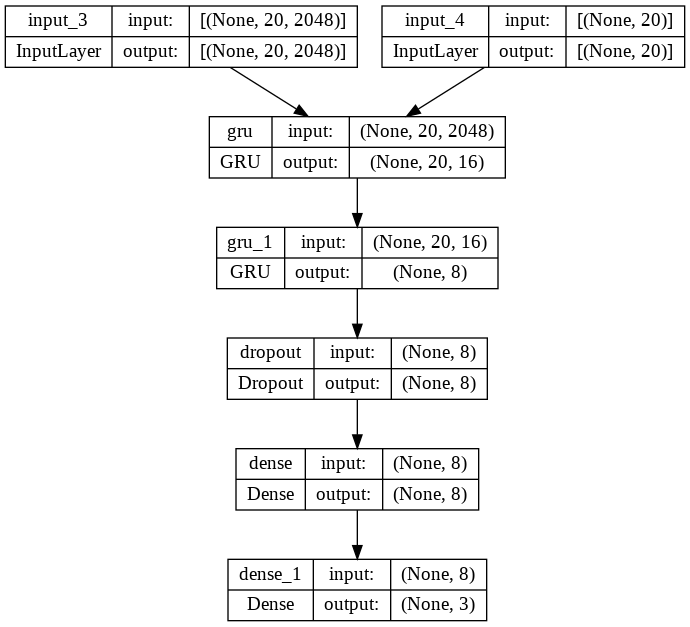

In [ ]:
plot_model(model,show_shapes=True)

## Inference

[Text(0, 0.5, 'E'), Text(0, 1.5, 'I'), Text(0, 2.5, 'N')]

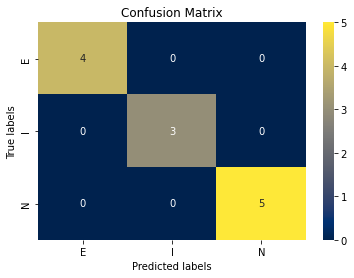

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cnf = confusion_matrix(np.squeeze(test_labels),np.argmax(y_pred,axis = 1))
ax= plt.subplot()
sns.heatmap(cnf, annot=True, fmt='g', ax=ax, cmap = 'cividis');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ticks = label_processor.get_vocabulary()
ax.xaxis.set_ticklabels(ticks); ax.yaxis.set_ticklabels(ticks)

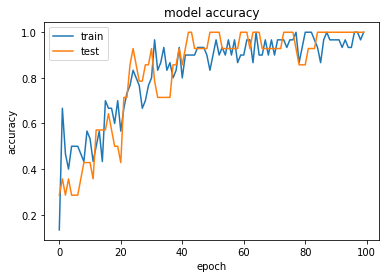

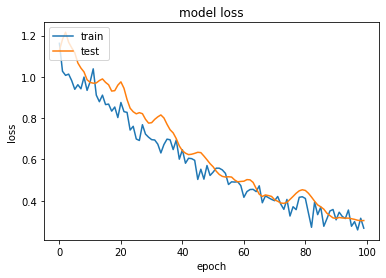

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

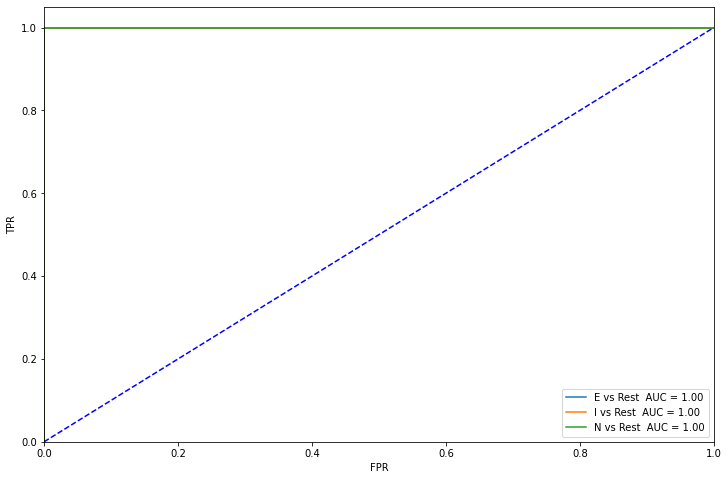

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

plt.figure(figsize = (12,8))
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = label_processor.get_vocabulary()
n_classes = len(label_processor.get_vocabulary())
y_test = np.squeeze(test_labels)
y_test = label_binarize(y_test,classes = np.unique(y_test))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[i],tpr[i], label = f"{classes[i]} vs Rest  AUC = {roc_auc[i]:.2f}")

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.legend(loc = 'lower right')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [ ]:
# Saving model 
model.save("CNN_RNN.h5")